## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [1]:
!pip install mlxtend -q
!pip install -U scikit-learn -q

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from mlxtend.plotting import plot_decision_regions
from itertools import product

from sklearn.linear_model import (LinearRegression, Ridge, Lasso, LassoCV)

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import (SelectKBest, mutual_info_regression,
                                       mutual_info_classif)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, OrdinalEncoder,
                                   StandardScaler, MinMaxScaler)
from sklearn.metrics import (accuracy_score, mean_squared_error)
from sklearn.neighbors import KNeighborsClassifier

import mlxtend
from collections import Counter


RANDOM_STATE = 42

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/IAD/4/penguins_data.csv')
data.head(10)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971
5,Gentoo,Biscoe,Yes,22,48.1,15.1,209.0,5500.0,MALE,8.45738,-26.22664
6,Gentoo,Biscoe,Yes,13,51.1,16.5,225.0,5250.0,MALE,8.20660,-26.36863
7,Gentoo,Biscoe,No,392,42.7,13.7,208.0,3950.0,FEMALE,8.14567,-26.59467
8,Adelie,Biscoe,Yes,14,39.6,20.7,191.0,3900.0,FEMALE,8.80967,-26.78958
9,Gentoo,Biscoe,Yes,735,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              344 non-null    object 
 1   Island               344 non-null    object 
 2   Clutch Completion    344 non-null    object 
 3   Date Egg             344 non-null    int64  
 4   Culmen Length (mm)   342 non-null    float64
 5   Culmen Depth (mm)    342 non-null    float64
 6   Flipper Length (mm)  342 non-null    float64
 7   Body Mass (g)        342 non-null    float64
 8   Sex                  334 non-null    object 
 9   Delta 15 N (o/oo)    330 non-null    float64
 10  Delta 13 C (o/oo)    331 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 29.7+ KB


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [6]:
# Проверим есть ли пропуски в данных
data.isnull().sum().sort_values(ascending = False)

,0
Delta 15 N (o/oo),14
Delta 13 C (o/oo),13
Sex,10
Culmen Depth (mm),2
Flipper Length (mm),2
Body Mass (g),2
Culmen Length (mm),2
Clutch Completion,0
Island,0
Species,0


In [7]:
# Удалим пропуски в данных
data.dropna(inplace = True)

In [8]:
# Посмотрим какие еть категориальные переменные и какие у них значения
cat_cols = data.select_dtypes(include = 'object').columns
for col in cat_cols:
  print(f'{col}: \n{data[col].unique()}\n')

Species: 
['Chinstrap' 'Gentoo' 'Adelie']

Island: 
['Dream' 'Biscoe' 'Torgersen']

Clutch Completion: 
['Yes' 'No']

Sex: 
['MALE' 'FEMALE' '.']



In [9]:
# Посмотрим на обьекты со значением . в признаке Sex
data[data['Sex'] == '.']

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
41,Gentoo,Biscoe,Yes,0,44.5,15.7,217.0,4875.0,.,8.04111,-26.18444


In [10]:
# Т.к такой обьект всего один, то удалим его
data = data[data['Sex'] != '.'].reset_index(drop=True)

In [11]:
# Для кодирования категориальных переменных используем OHE, так как он подходит для категорий без порядка и лучше воспринимается большинством моделей
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output = False, drop='first')

In [12]:
# Отберем столбцы для кодироавния
ohe_columns = ['Island', 'Clutch Completion', 'Sex']

# Закодируем
ohe_data = ohe.fit_transform(data[ohe_columns])
ohe_data = pd.DataFrame(ohe_data, columns = ohe.get_feature_names_out()).reset_index(drop=True)

In [13]:
# Целевую переменную `'Species'` закодируем при помощи OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
target = oe.fit_transform(data[['Species']])

In [14]:
# Масштабируем остальные призанки
scaler = StandardScaler()
to_scale = ['Date Egg','Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
data[to_scale] = scaler.fit_transform(data[to_scale])
data.head()

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,0.089268,1.251168,1.004166,-0.374256,-0.821712,MALE,2.328971,1.041960
1,Chinstrap,Dream,Yes,1.312996,0.209534,0.342369,-0.230754,-0.326679,FEMALE,0.271173,1.512579
2,Gentoo,Biscoe,Yes,1.323223,0.447100,-1.846654,0.630256,0.415869,FEMALE,-1.350901,0.456424
3,Chinstrap,Dream,Yes,-1.178773,0.209534,-0.268521,-0.733010,-1.192986,FEMALE,1.603036,1.138336
4,Gentoo,Biscoe,Yes,-1.168547,0.794311,-1.388486,0.128000,0.508688,FEMALE,-1.041551,-0.571185


Целевую категориальную переменную закодируйте в ординальном порядке: Chinstrap = 0, Gentoo = 1, Adelie = 2. Можно воспользоваться [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Теперь сохраним информацию о признаках в переменную
`X`, а о целевой переменной – в переменную `y`.

In [15]:
#Cохраним информацию о признаках в переменную X, а о целевой переменной – в переменную y
X = pd.concat([data.drop(columns=['Species', 'Island', 'Clutch Completion', 'Sex']), ohe_data], axis=1)
y = pd.Series(target.flatten(), name='Species')

print(X.shape, y.shape)

(324, 11) (324,)


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

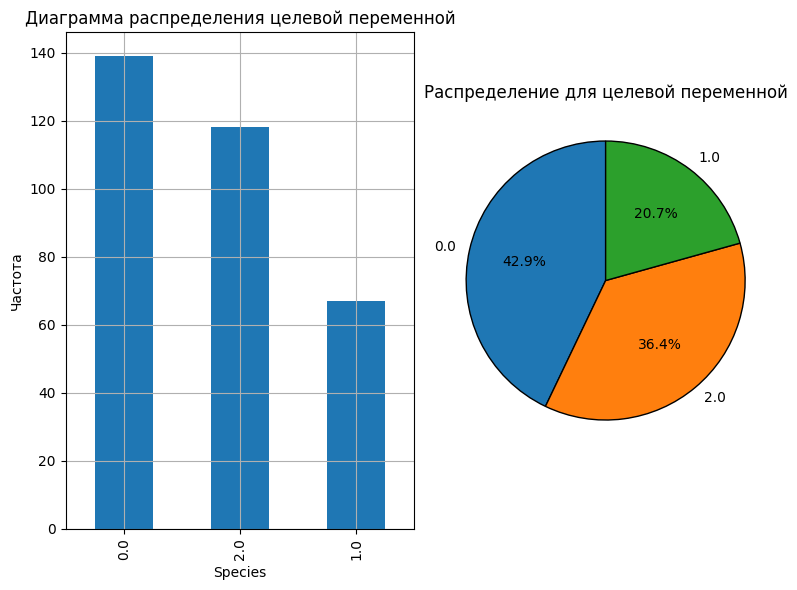

In [16]:
# Посмотрим на рспределение классов в целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
y.value_counts().plot.bar(ax=axes[0])
axes[0].set_title(f'Диаграмма распределения целевой переменной', fontsize=12)
axes[0].grid(True)
axes[0].set_ylabel('Частота')
axes[0].tick_params(axis='x', rotation=90)

y.value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    ax=axes[1]
)
axes[1].set_title(f'Распределение для целевой переменной', fontsize=12)
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

Стратификация необходима для поддержания баланса классов в тренировочной и тестовой выборках, чтобы пропорции классов целевой переменной оставались такими же, как в исходных данных

In [17]:
# Разделим данные на тренировончные и тесовые при помощи train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [18]:
features = ['Flipper Length (mm)', 'Body Mass (g)']
X_train_features = X_train[features]
X_test_features = X_test[features]

In [19]:
neighbors = [1, 3, 5, 10, 15, 25]

res = []
models = []
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n, metric='euclidean')
    model.fit(X_train_features, y_train)

    models.append(model)
    train_score = model.score(X_train_features, y_train)
    test_score = model.score(X_test_features, y_test)

    res.append({'n_neighbors': n, 'train_score': train_score, 'test_score': test_score})

res = pd.DataFrame(res).set_index('n_neighbors')

round(res,3)

,train_score,test_score
n_neighbors,,
1,0.978,0.796
3,0.876,0.816
5,0.845,0.847
10,0.810,0.806
15,0.823,0.806
25,0.805,0.837


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/pytho

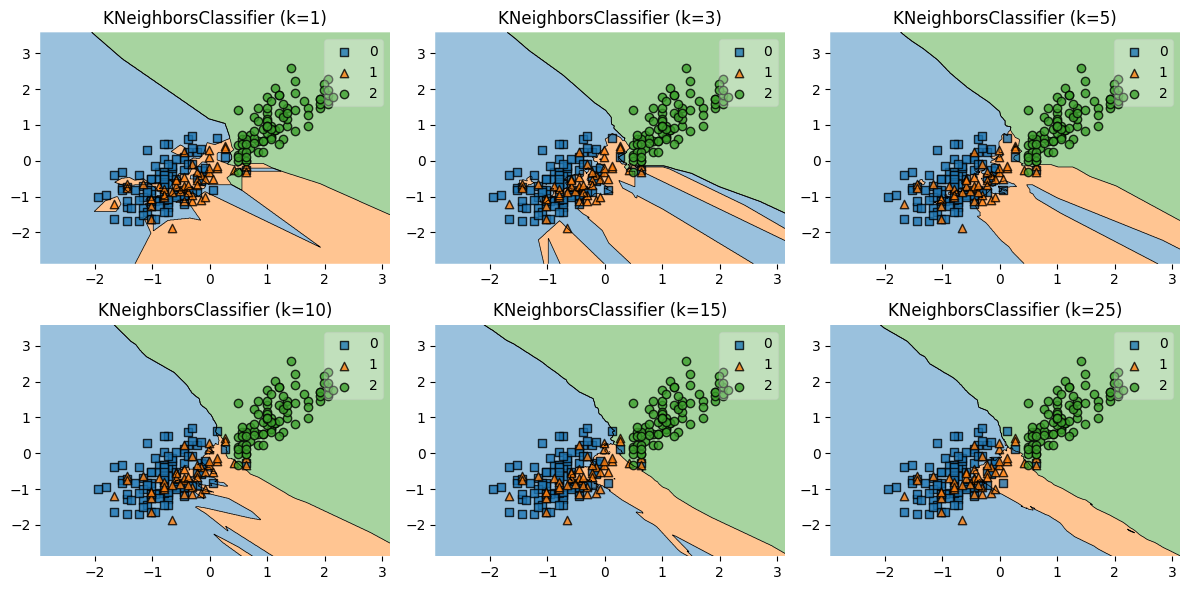

In [20]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 3)

for clf, grid_pos in zip(models, product(range(2), range(3))):
    ax = plt.subplot(gs[grid_pos])
    plot_decision_regions(X_train_features.to_numpy(), y_train.to_numpy().astype(np.int_), clf=clf, legend=1)
    ax.set_title(f"KNeighborsClassifier (k={clf.n_neighbors})")

plt.tight_layout()
plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

* Оптимальное количество соседей для классификатора — k=5, так как при этом значении достигается наилучший баланс между качеством на обучающей 84.5% и тестовой 84.7% выборках  

* При меньших значениях k, особенно при k=1,  модель переобучается - границы решений слишком сложные, модель слишком сильно подстравивается под тренировочную выборку и имеет плохую обобщающую способность, а разница между точностью на обучающей 97.8% и тестовой 79.6% выборках слишком велика

* При увеличении k границы решений становятся слишком простыми, что говорит о недообучении — модель не может уловить сложные зависимости и плохо разделяет классы


### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

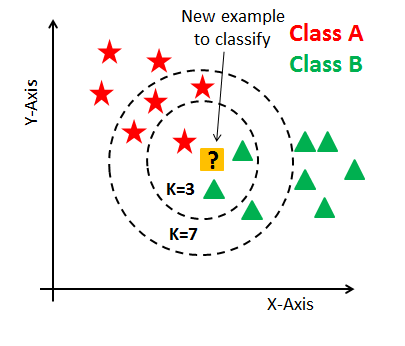

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [21]:

class KNN:
    def __init__(self, k:int):
      self.k = k
      self.X = None
      self.y = None

    def fit(self, X, y):
      X = np.array(X)
      y = np.array(y)
      self.X = X
      self.y = y

    def predict(self, X):
      X = np.array(X)
      predictions = []
      for x in X:
          distances = self.count_distance(x, self.X)
          k_indices = np.argsort(distances)[:self.k]
          k_nearest_labels = self.y[k_indices]
          label = Counter(k_nearest_labels).most_common(1)[0][0]
          predictions.append(label)
      return np.array(predictions)

    def count_distance(self, x, y):
      x = np.asarray(x)
      distances = np.linalg.norm(y - x, axis=1)
      return distances


In [22]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [23]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

In [24]:
my_knn_1 = KNN(k=1)
my_knn_1.fit(X_train, y_train)
y_pred = my_knn_1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9897959183673469


In [25]:
neighbors = [1, 3, 5, 10, 15, 25]

my_res = []
my_models = []
for n in neighbors:
    my_knn = KNN(n)
    my_knn.fit(X_train, y_train)

    train_preds = my_knn.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)

    test_preds = my_knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)

    my_models.append(my_knn)
    my_res.append({'n_neighbors': n, 'train_score': train_accuracy, 'test_score': test_accuracy})

my_res = pd.DataFrame(my_res).set_index('n_neighbors')

my_res

,train_score,test_score
n_neighbors,,
1,1.000000,0.989796
3,1.000000,0.989796
5,1.000000,0.989796
10,1.000000,1.000000
15,0.995575,1.000000
25,0.995575,1.000000


### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [26]:
data = pd.read_csv('/content/drive/MyDrive/IAD/4/diamonds.csv', index_col = 'Unnamed: 0')
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [28]:
# Проверим, есть ли в данных пропуски
data.isnull().sum()

,0
carat,0
cut,0
color,0
clarity,0
depth,0
table,0
price,0
x,0
y,0
z,0


В данных нет ненужных столбцов

**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

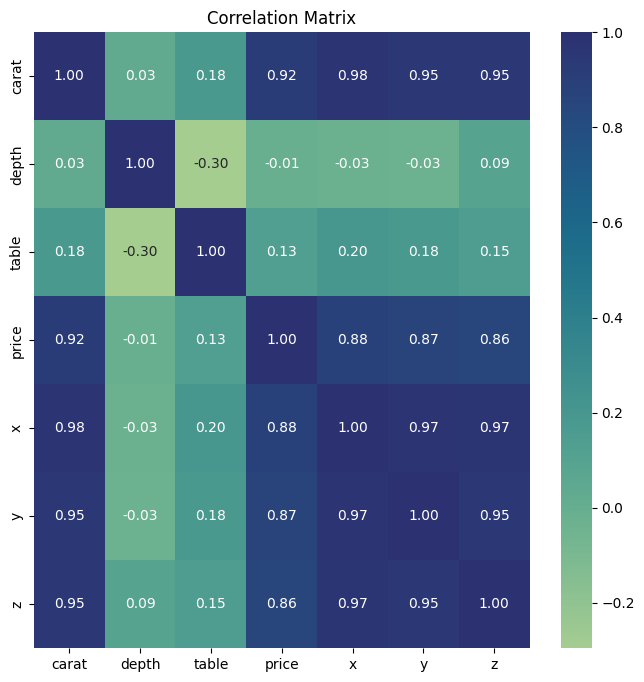

In [29]:
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="crest", fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [30]:
target_corr = correlation_matrix['price'].sort_values(ascending=False)
print("Correlation with target variable (price):\n", target_corr )

Correlation with target variable (price):
 price    1.000000
carat    0.921591
x        0.884435
y        0.865421
z        0.861249
table    0.127134
depth   -0.010647
Name: price, dtype: float64


Наибольшую корреляцию с целевой переменной имеют признаки `'carat'`, `'x'`, pfntv blen `'y'` и `'z'`, а `'table'` и `'depth'` имеют очень низкую корреляцию

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

In [31]:
ohe_columns = data.select_dtypes(include=['object']).columns
sc_columns = data.select_dtypes(include=['float64', 'int64']).drop(columns = 'price').columns

encoder = OneHotEncoder(drop = 'first', sparse_output=False)
ohe_data = encoder.fit_transform(data[ohe_columns])
ohe_data = pd.DataFrame(ohe_data, columns=encoder.get_feature_names_out(ohe_columns))
ohe_data.head()

,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
# Соединим закодированные признаки с вещественными
data = pd.concat([data.drop(ohe_columns, axis=1).reset_index(drop=True), ohe_data], axis=1)
data.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [33]:
# Разделим данные на тренировочную и тестовую выборки
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

In [34]:
# Отскалиуем вещественнеы признаки в тренировочное и тестовой выборках

scaler = StandardScaler()
X_train[sc_columns] = scaler.fit_transform(X_train[sc_columns])
X_test[sc_columns] = scaler.transform(X_test[sc_columns])

* После стандартизации коэффициент показывает, как изменится
y, если признак увеличится на 1 стандартное отклонение

* В исходной модели признаки могли иметь разные масштабы, и коэффициенты могли зависеть от масштаба признаков

* После стандартизации все признаки имеют среднее 0 и дисперсию 1, и теперь можно сравнивать значения коэффициентов между собой и определять какие признаки более важны

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print(f"Train MSE: {mean_squared_error(y_train, y_pred_train)}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test)}")

Train MSE: 1290541.9147450614
Test MSE: 1244765.4357158695


**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [36]:
coefs = pd.DataFrame({'feature': lr.feature_names_in_, 'coef': lr.coef_})

# Отберем только вещественные переменные
coefs_num = coefs[coefs['feature'].isin(sc_columns)]

# Посмотрим на одули коэффициентов
coefs_num['coef'] = np.abs(coefs_num['coef'])

coefs_num.sort_values(by='coef', ascending=False)

<ipython-input-36-eeeb17975514>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_num['coef'] = np.abs(coefs_num['coef'])


,feature,coef
0,carat,5338.615671
3,x,1100.418850
1,depth,90.173817
2,table,60.332280
5,z,34.258945
4,y,6.458917


Вещественные переменные, коэффициенты которых на порядок превышают другие

* `'carat'`
* `'x'`

**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [38]:
model_lasso = Lasso(alpha = 10)
model_lasso.fit(X_train, y_train)
y_pred_train_Lasso = model_lasso.predict(X_train)

model_ridge = Ridge(alpha = 10)
model_ridge .fit(X_train, y_train)
y_pred_train_Ridge = model_ridge .predict(X_train)


print(f"Train MSE Lasso: {mean_squared_error(y_train, y_pred_train_Lasso)}")
print()
print(f"Train MSE Ridge: {mean_squared_error(y_train, y_pred_train_Ridge)}")

Train MSE Lasso: 1532211.8153978987

Train MSE Ridge: 1294769.584930516


In [39]:
# Создаём таблицы коэффициентов
coefs_lasso = pd.DataFrame({'feature': X_train.columns, 'coef': model_lasso.coef_})
coefs_ridge = pd.DataFrame({'feature': X_train.columns, 'coef': model_ridge.coef_})

# Оставляем только вещественные переменные
coefs_lasso_num = coefs_lasso[coefs_lasso['feature'].isin(sc_columns)]
coefs_ridge_num = coefs_ridge[coefs_ridge['feature'].isin(sc_columns)]

# Берем модуль коэффициентов
coefs_lasso_num['coef'] = np.abs(coefs_lasso_num['coef'])
coefs_ridge_num['coef'] = np.abs(coefs_ridge_num['coef'])

# Сортируем по убыванию значимости
coefs_lasso_num = coefs_lasso_num.sort_values(by='coef', ascending=False)
coefs_ridge_num = coefs_ridge_num.sort_values(by='coef', ascending=False)

print("\nLasso Regression:")
display(coefs_lasso_num)

print("\nRidge Regression")
display(coefs_ridge_num)


Lasso Regression:


<ipython-input-39-dd1f7be3218c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_lasso_num['coef'] = np.abs(coefs_lasso_num['coef'])
<ipython-input-39-dd1f7be3218c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_ridge_num['coef'] = np.abs(coefs_ridge_num['coef'])


,feature,coef
0,carat,4756.602190
3,x,681.275333
1,depth,153.122715
2,table,109.868576
5,z,6.279439
4,y,0.000000



Ridge Regression


,feature,coef
0,carat,5286.285876
3,x,1062.006514
1,depth,93.746314
2,table,63.430106
5,z,33.689994
4,y,5.916126


Lasso занулила коэффициент y и значительно уменьшила все веса, а Ridge Почти не изменила веса. В изначальной регрессии коэффициенты были выше, особенно у carat и x

**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [40]:
alpha_values = [0.1, 1, 10, 50, 75, 100, 150, 200]

In [41]:
lasso_norms = []
ridge_norms = []

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_norms.append(np.linalg.norm(lasso.coef_))

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    ridge_norms.append(np.linalg.norm(ridge.coef_))

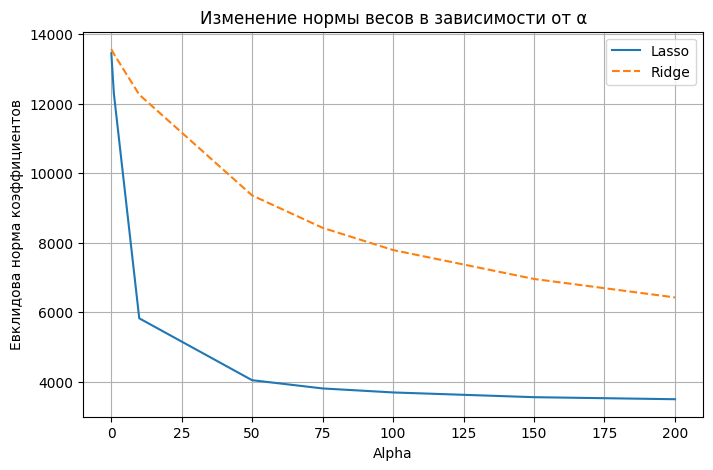

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, lasso_norms, linestyle='-', label="Lasso")
plt.plot(alpha_values, ridge_norms, linestyle='--', label="Ridge")
plt.xlabel("Alpha")
plt.ylabel("Евклидова норма коэффициентов")
plt.title("Изменение нормы весов в зависимости от α")
plt.legend()
plt.grid()
plt.show()

* Lasso резко уменьшает норму весов и обнуляет некоторые коэф при увеличении α
* Ridge уменьшает норму плавнее, так как не зануляет коэф, а просто снижает влияние признаков

Lasso-регрессию используют для отбора признаков, потому что она накладывает штраф за сумму модулей коэффициенто, что приводит к тому, что модель принудительно обнуляет коэффициенты наименее значимых признаков

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [58]:
alpha_values = [0.1, 0,2, 0,3, 1, 10, 50, 75, 100, 150, 200]

In [59]:
lasso_cv = LassoCV(alphas=alpha_values, cv=5,max_iter=5000, random_state=RANDOM_STATE)
lasso_cv.fit(X_train, y_train)

mse_mean = lasso_cv.mse_path_.mean(axis=1)
min_alpha = lasso_cv.alphas_[np.argmin(mse_mean)]

print(f"Оптимальное значение alpha: {min_alpha}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19332921937.709106, tolerance: 48315572.75557969
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did

Оптимальное значение alpha: 0.1


In [60]:
mse_mean

array([2454496.08920843, 2410375.23770446, 2253986.69620221,
       2148717.58551878, 1953775.26873005, 1531831.97540655,
       1335191.08155481, 1312087.56943032, 1298215.93967038,
       1295967.96385761, 1297189.835037  , 1297189.83506999])

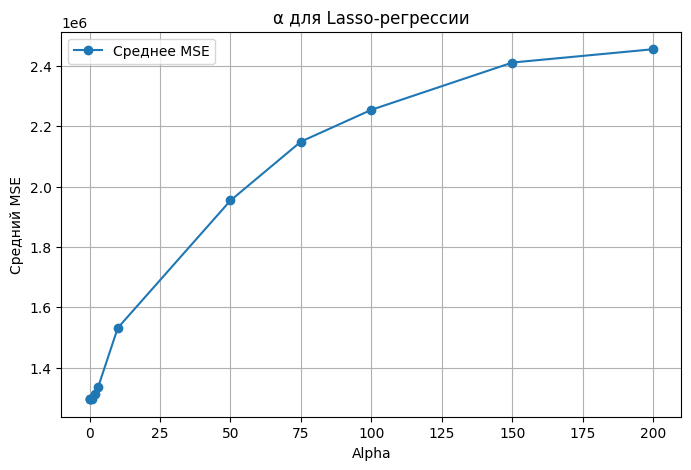

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(lasso_cv.alphas_, mse_mean, marker='o', linestyle='-', label="Среднее MSE")
plt.xlabel("Alpha")
plt.ylabel("Средний MSE")
plt.title("α для Lasso-регрессии")
plt.legend()
plt.grid()
plt.show()

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [47]:
lasso_final = Lasso(alpha=0.1, max_iter=5000)
lasso_final.fit(X_train, y_train)

Lasso(alpha=0.1, max_iter=5000)

In [48]:
coefs_final = pd.DataFrame({
    'feature': X_train.columns,
    'coef': lasso_final.coef_
})

zero_coefs = coefs_final[coefs_final['coef'] == 0]
nonzero_coefs = coefs_final[coefs_final['coef'] != 0]

print("Зануленные коэффициенты:")
display(zero_coefs)

print("\nОстальные:")
display(nonzero_coefs.sort_values(by='coef', ascending=False))

Зануленные коэффициенты:


,feature,coef



Остальные:


,feature,coef
16,clarity_IF,5402.396479
0,carat,5332.422145
21,clarity_VVS1,5046.644984
22,clarity_VVS2,4974.320848
19,clarity_VS1,4604.228786
20,clarity_VS2,4283.913095
17,clarity_SI1,3699.213091
18,clarity_SI2,2729.882663
7,cut_Ideal,836.160368
8,cut_Premium,767.655001


* Наиболее информативными признаками оказались чистота бриллианта и карат

* Чистота имеет наибольшие положительные коэффициенты, поскольку более чистые бриллианты ценятся выше

* Карат также сильно влияет на цену, так как чем больше вес, тем дороже камень

* Качество огранки также влияет на цену

* Менее значимыми оказались признаки, связанные с цветом бриллианта. У них отрицательные коэффициенты: чем хуже цвет, тем дешевле бриллиант

* Признаки, связанные с геометрическими размерами имеют небольшие коэффициенты, причем y и z практически занулены. Это говорит о том, что размер сам по себе не так важен, если уже учтен карат

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [49]:
final_preds = lasso_final.predict(X_test)

print(f"Test MSE Lasso: {mean_squared_error(y_test, final_preds)}")

Test MSE Lasso: 1244336.150823827


In [50]:
print(f"Test MSE 3.7: {mean_squared_error(y_test, y_pred_test)}")

Test MSE 3.7: 1244765.4357158695


* Lasso-регрессия показывает меньшую ошибку по сравнению с обычной линейной регрессией. Это говорит о том, что она лучше справляется с предсказаниями

* В обычной линейной регрессии, вероятно, возникла проблема переобучения из-за мультиколлинеарности

Поэтому Lasso-регрессию стоит использовать для предсказаний, так как она дает более точные результаты